# Build the training loop

We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The paramters are updated after each mini batch. Networks converge much faster using mini batches because the parameters are updated more often.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``optimizer.step()`` is called.

# Assignments

Try and add these modifications (might require some Googleing -- an important skill in deep learning):
- Kaiming He initialization instead of Xavier Glorot
- add an extra layer
- use the relu activation function
- add momentum to the optimizer
- use the ADAM optimizer instead of stochastic gradient descent

## Initialization

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

## MNIST
First let's load the MNIST dataset and plot a few examples:

In [2]:
data_path = "../Week_3/temp/"
mnist_trainset = MNIST(data_path, train=True, download=True)
mnist_testset = MNIST(data_path, train=False, download=True)

In [3]:
# To speed up training we'll only work on a subset of the data
# ***Own Notes***
# We don't change neither the dataset nor the corresponding targets
# throughout this notebook, this is why I have indicated them as constants.
X_TRAIN = mnist_trainset.data[:1000].view(-1, 784).float()
TARGETS_TRAIN = mnist_trainset.targets[:1000]

X_VALID = mnist_trainset.data[1000:1500].view(-1, 784).float()
TARGETS_VALID = mnist_trainset.targets[1000:1500]

X_TEST = mnist_testset.data[:500].view(-1, 784).float()
TARGETS_TEST = mnist_testset.targets[:500]

## Kaiming He initialization
Using Kaming He initialization instead of Xavier Glorot.

In [4]:
#Hyperparameters
NUM_CLASSES = 10
NUM_LAYER1 = 512
num_features = X_TRAIN.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        return x


net = Net(num_features, NUM_LAYER1, NUM_CLASSES)

Normalizes the data

In [5]:
# normalize the inputs
X_TRAIN.div_(255)
X_VALID.div_(255)
X_TEST.div_(255)

# setting hyperparameters and gettings epoch sizes
BACTH_SIZE = 100
NUM_EPOCHS = 200

get_slice = lambda i, size: range(i * size, (i + 1) * size)

### Training function

In [6]:
def training_func(network, optim_func, loss_func, batch_size, num_epochs):
    # we could have done this ourselves,
    # but we should be aware of sklearn and its tools
    from sklearn.metrics import accuracy_score
    
    # setting up lists for handling loss/accuracy
    train_acc, train_loss = [], []
    valid_acc, valid_loss = [], []
    
    num_samples_train = X_TRAIN.shape[0]
    num_batches_train = num_samples_train // BACTH_SIZE
    num_samples_valid = X_VALID.shape[0]
    num_batches_valid = num_samples_valid // BACTH_SIZE
    
    for epoch in range(num_epochs):
        # Forward -> Backprob -> Update params
        ## Train
        cur_loss_train = 0
        cur_loss_valid = 0
        network.train()
        for i in range(num_batches_train):
            optim_func.zero_grad()
            slce = get_slice(i, batch_size)
            output = network(X_TRAIN[slce])
            
            # compute gradients given loss
            target_batch = TARGETS_TRAIN[slce]
            batch_loss = loss_func(output, target_batch)
            batch_loss.backward()
            optim_func.step()
            
        network.eval()
        ### Evaluate training
        train_preds, train_targs = [], []
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size)
            output = network(X_TRAIN[slce])
            
            # compute gradients given loss
            target_batch = TARGETS_TRAIN[slce]
            batch_loss = loss_func(output, target_batch)
            cur_loss_train += batch_loss 
            
            preds = torch.max(output, 1)[1]
            
            train_targs += list(TARGETS_TRAIN[slce].numpy())
            train_preds += list(preds.data.numpy())
        train_loss.append(cur_loss_train / batch_size)
        
        ### Evaluate validation
        val_preds, val_targs = [], []
        for i in range(num_batches_valid):
            slce = get_slice(i, batch_size)
            output = net(X_VALID[slce])
            
            # compute gradients given loss
            target_batch = TARGETS_VALID[slce]
            batch_loss = loss_func(output, target_batch)
            
            preds = torch.max(output, 1)[1]
            
            val_targs += list(TARGETS_VALID[slce].numpy())
            val_preds += list(preds.data.numpy())
            cur_loss_valid += batch_loss
        valid_loss.append(cur_loss_valid / batch_size)
            

        train_acc_cur = accuracy_score(train_targs, train_preds)
        valid_acc_cur = accuracy_score(val_targs, val_preds)
        
        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)
        
        if epoch % (num_epochs // 10) == 0:
            # We print roughly at every 10% increment through our dataset.
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                    epoch+1, train_loss[-1], train_acc_cur, valid_acc_cur))

    # ***Own Notes***
    # Detatching those gosh darn tensors..
    train_loss = torch.tensor(train_loss)
    train_loss.detach().numpy()
    valid_loss = torch.tensor(valid_loss)
    valid_loss.detach().numpy()
    
    # Plotting
    # So that I don't have to return anything
    
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    epoch = np.arange(len(train_acc))
    ax1.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
    ax1.legend(['Train Accucary','Validation Accuracy'])
    ax1.set_xlabel('Updates')
    ax1.set_ylabel('Acc')
    # ax1.set_ylim([0,1])
    
    ax2.plot(epoch, train_loss, 'r', epoch, valid_loss, 'b')
    ax2.legend(['Train Loss','Validation Loss'])
    ax2.set_xlabel('Updates')
    ax2.set_ylabel('Loss')
    # ax2.set_ylim([0,1])
    fig.tight_layout()
    
    min_valid_loss_indx = np.argmin(valid_loss)
    print(f"\nThe lowest validation loss was found at epoch: {min_valid_loss_indx + 1}! With values:")
    print(f"Validation loss: \t{valid_loss[min_valid_loss_indx]:.3f}\nTrain loss: \t\t{train_loss[min_valid_loss_indx]:.3f}")
    print(f"Train accuracy: \t{train_acc[min_valid_loss_indx]:.3f}\nTrain loss: \t\t{valid_acc[min_valid_loss_indx]:.3f}")

In [7]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.223048 , Train acc 0.151000, Valid acc 0.126000
Epoch 21 : Train Loss 0.073241 , Train acc 0.834000, Valid acc 0.778000
Epoch 41 : Train Loss 0.051775 , Train acc 0.883000, Valid acc 0.820000
Epoch 61 : Train Loss 0.042204 , Train acc 0.906000, Valid acc 0.838000
Epoch 81 : Train Loss 0.036343 , Train acc 0.913000, Valid acc 0.852000
Epoch 101 : Train Loss 0.032195 , Train acc 0.924000, Valid acc 0.854000
Epoch 121 : Train Loss 0.029003 , Train acc 0.929000, Valid acc 0.856000
Epoch 141 : Train Loss 0.026412 , Train acc 0.935000, Valid acc 0.854000
Epoch 161 : Train Loss 0.024233 , Train acc 0.941000, Valid acc 0.854000
Epoch 181 : Train Loss 0.022355 , Train acc 0.945000, Valid acc 0.852000

The lowest validation loss was found at epoch: 200! With values:
Validation loss: 	0.026
Train loss: 		0.021
Train accuracy: 	0.954
Train loss: 		0.856


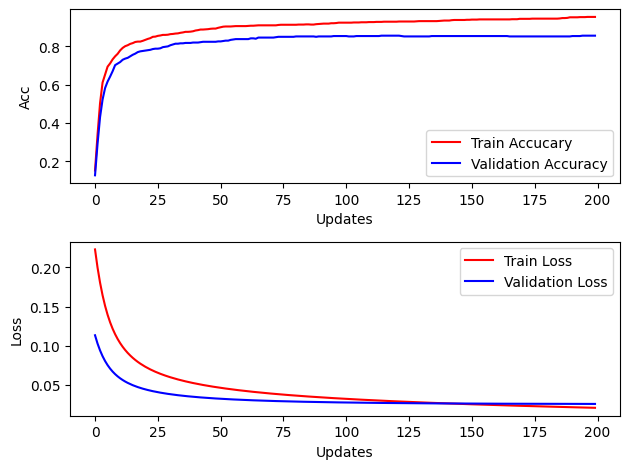

In [8]:
training_func(net, optimizer, criterion, BACTH_SIZE, NUM_EPOCHS)

### Extra Layer ReLU and Momentum

In [9]:
#Hyperparameters
num_classes = 10
num_l1 = [512, 256]
num_features = X_TRAIN.shape[1]

# define network
class NetWithExtraLayer(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(NetWithExtraLayer, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden[0], num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden[0]), 0))
        # hidden layer
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden[1], num_hidden[0])))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden[1]), 0))
        # hidden layer
        self.W_3 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden[1])))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        x = F.linear(x, self.W_3, self.b_3)
        return x


net_with_extra_layer = NetWithExtraLayer(num_features, num_l1, num_classes)

In [10]:
optimizer_with_momentum = optim.SGD(net_with_extra_layer.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.178085 , Train acc 0.504000, Valid acc 0.856000
Epoch 21 : Train Loss 0.008041 , Train acc 0.996000, Valid acc 0.856000
Epoch 41 : Train Loss 0.002491 , Train acc 1.000000, Valid acc 0.856000
Epoch 61 : Train Loss 0.001280 , Train acc 1.000000, Valid acc 0.856000
Epoch 81 : Train Loss 0.000818 , Train acc 1.000000, Valid acc 0.856000
Epoch 101 : Train Loss 0.000586 , Train acc 1.000000, Valid acc 0.856000
Epoch 121 : Train Loss 0.000450 , Train acc 1.000000, Valid acc 0.856000
Epoch 141 : Train Loss 0.000361 , Train acc 1.000000, Valid acc 0.856000
Epoch 161 : Train Loss 0.000300 , Train acc 1.000000, Valid acc 0.856000
Epoch 181 : Train Loss 0.000255 , Train acc 1.000000, Valid acc 0.856000

The lowest validation loss was found at epoch: 1! With values:
Validation loss: 	0.026
Train loss: 		0.178
Train accuracy: 	0.504
Train loss: 		0.856


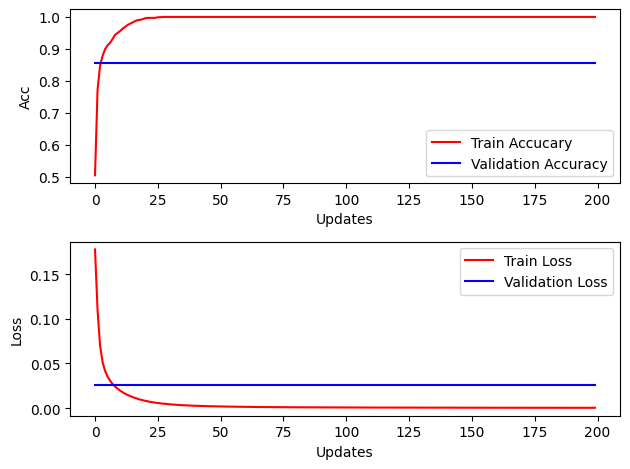

In [11]:
training_func(net_with_extra_layer, optimizer_with_momentum, criterion, BACTH_SIZE, NUM_EPOCHS)

### Extra Layer with ReLU and ADAM

In [12]:
net_with_extra_layer2 = NetWithExtraLayer(num_features, num_l1, num_classes)
optimizer_adam = optim.Adam(net_with_extra_layer2.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.052753 , Train acc 0.849000, Valid acc 0.856000
Epoch 21 : Train Loss 0.020332 , Train acc 0.957000, Valid acc 0.856000
Epoch 41 : Train Loss 0.000005 , Train acc 1.000000, Valid acc 0.856000
Epoch 61 : Train Loss 0.000001 , Train acc 1.000000, Valid acc 0.856000
Epoch 81 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.856000
Epoch 101 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.856000
Epoch 121 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.856000
Epoch 141 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.856000
Epoch 161 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.856000
Epoch 181 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.856000

The lowest validation loss was found at epoch: 1! With values:
Validation loss: 	0.026
Train loss: 		0.053
Train accuracy: 	0.849
Train loss: 		0.856


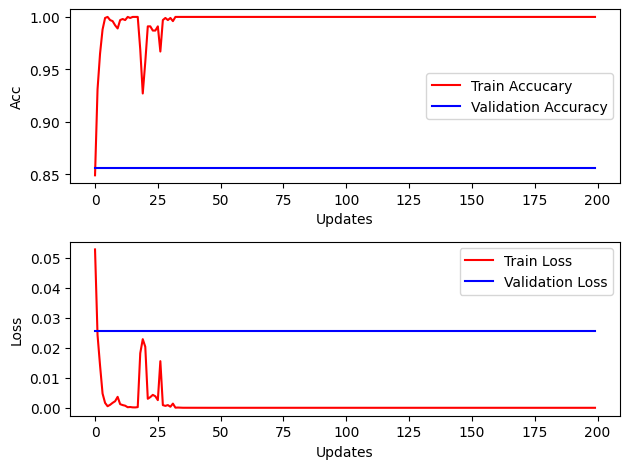

In [13]:
training_func(net_with_extra_layer2, optimizer_adam, criterion, BACTH_SIZE, NUM_EPOCHS)

### Advanced - Regularization

Regularization is VERY important in practice and is used practically every time.
Many important results are completely dependent on clever use of regularization, and it is something you need to become familiar with if you want to work with deep learning.

- add L1 or L2 weight regularization (aka. weight decay) 
- add dropout to the network (**note** the `net.train()` and `net.eval()` are already in the code)
- add batchnorm

__Pointers on regularization hyperparameter:__
1. L2 and [L1 regularization](http://pytorch.org/docs/master/nn.html#torch.nn.L1Loss) (weight decay of optimization functions) 
  - Normal ranges: 1e-4  -  1e-8
1. [Dropout](http://pytorch.org/docs/master/nn.html?highlight=dropout#torch.nn.Dropout). Dropout rate 0.1-0.5
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate random dropout, and call `net.eval()` to deactivate dropout while validating or running inference with model.
1. [Batchnorm](http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm1d): Batchnorm also acts as a regularizer - Often very useful (faster and better convergence)
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate, and call `net.eval()` to have a non-stochastic variant while validating or running inference with model.

In [14]:
net_with_extra_layer3 = NetWithExtraLayer(num_features, num_l1, num_classes)
optimizer_adam_weight_decay = optim.Adam(net_with_extra_layer3.parameters(), lr=0.01, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.067788 , Train acc 0.798000, Valid acc 0.856000
Epoch 21 : Train Loss 0.000016 , Train acc 1.000000, Valid acc 0.856000
Epoch 41 : Train Loss 0.000008 , Train acc 1.000000, Valid acc 0.856000
Epoch 61 : Train Loss 0.000007 , Train acc 1.000000, Valid acc 0.856000
Epoch 81 : Train Loss 0.000006 , Train acc 1.000000, Valid acc 0.856000
Epoch 101 : Train Loss 0.000006 , Train acc 1.000000, Valid acc 0.856000
Epoch 121 : Train Loss 0.000006 , Train acc 1.000000, Valid acc 0.856000
Epoch 141 : Train Loss 0.000006 , Train acc 1.000000, Valid acc 0.856000
Epoch 161 : Train Loss 0.000006 , Train acc 1.000000, Valid acc 0.856000
Epoch 181 : Train Loss 0.000006 , Train acc 1.000000, Valid acc 0.856000

The lowest validation loss was found at epoch: 1! With values:
Validation loss: 	0.026
Train loss: 		0.068
Train accuracy: 	0.798
Train loss: 		0.856


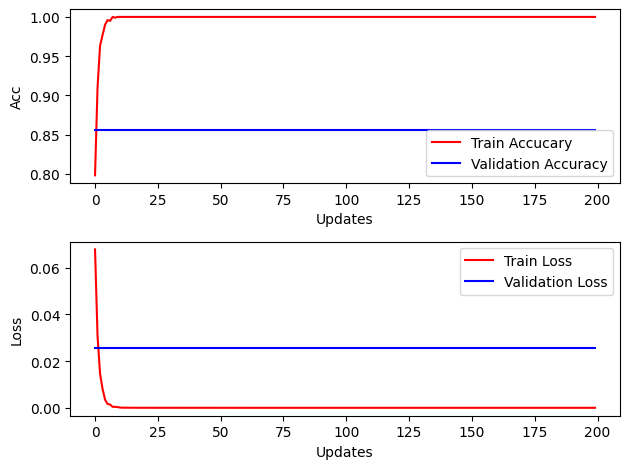

In [15]:
training_func(net_with_extra_layer3, optimizer_adam_weight_decay, criterion, BACTH_SIZE, NUM_EPOCHS)

## Comment
I honestly don't know what's up with my validation....